In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
headers = ['url', 'price', 'title', 'geo_lat', 'geo_long', 'rating',
           'number_reviews', 'sleeps', 'bedrooms', 'bathrooms',
           'min_stay', 'distance_to_TS']

data_file = 'data/homeaway_rentals_nyc_PARSED.csv' 
df = pd.read_csv(data_file, sep='\t', header=0, names=headers, index_col=0)
# df['distance_to_TS_mile']
df = df[df.distance_to_TS < 60000]
df.describe()

,price,geo_lat,geo_long,rating,number_reviews,sleeps,bedrooms,bathrooms,min_stay,distance_to_TS
count,3717.000000,3717.000000,3717.000000,1475.000000,3717.000000,3717.000000,3717.000000,3717.000000,3717.000000,3717.000000
mean,318.503632,40.740040,-73.972358,4.564339,6.465160,4.546946,1.670702,1.224913,9.472962,8777.994888
std,271.132441,0.049464,0.057537,0.614956,16.149953,1.828422,0.939067,0.547028,12.076079,8171.555161
min,0.000000,40.551015,-74.349691,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,51.000000
25%,157.000000,40.716084,-73.993742,4.400000,0.000000,3.000000,1.000000,1.000000,2.000000,2845.000000
50%,243.000000,40.743869,-73.979954,4.800000,0.000000,4.000000,2.000000,1.000000,3.000000,5881.000000
75%,386.000000,40.766514,-73.952469,5.000000,4.000000,6.000000,2.000000,1.000000,9.000000,12669.000000
max,2688.000000,40.974511,-73.679948,5.000000,175.000000,9.000000,6.000000,6.000000,90.000000,47405.000000


In [3]:
# # Not all rentals have reviews
# df_with_reviews = df[df.rating.notnull()]

# # Plot some basic graphs to understand the data
# fig_overview, ax_overview = plt.subplots(2, 2, figsize=(15, 15))

# ax_overview[0][0].hist(df.bedrooms.as_matrix())
# ax_overview[0][0].set_title('Distribution of Bedroom Count')
# ax_overview[0][0].set_xlabel('# Bedrooms')
# ax_overview[0][0].set_ylabel('Frequency')

# ax_overview[0][1].hist(df_with_reviews.rating.as_matrix())
# ax_overview[0][1].set_title('Distribution of Ratings')
# ax_overview[0][1].set_xlabel('Rating')
# ax_overview[0][1].set_ylabel('Frequency')
# ax_overview[0][1].xaxis.set_ticks(np.arange(1,5,1))

# ax_overview[1][0].hist(df.price.as_matrix())
# ax_overview[1][0].set_title('Distribution of Nightly Rental Prices')
# ax_overview[1][0].set_xlabel('Rental Price per Night')
# ax_overview[1][0].set_ylabel('Frequency')

# ax_overview[1][1].hist(df.distance_to_TS.as_matrix())
# ax_overview[1][1].set_title('Distribution of Driving Distance to Times Square')
# ax_overview[1][1].set_xlabel('Driving distance to Time Square (m)')
# ax_overview[1][1].set_ylabel('Frequency')

In [4]:
# Assume if no reviews, rating = 5
df.rating = df.rating.fillna(5)
df.head()

,url,price,title,geo_lat,geo_long,rating,number_reviews,sleeps,bedrooms,bathrooms,min_stay,distance_to_TS
0,https://www.homeaway.com/vacation-rental/p353201,100,Modern Studio Haven in Quiet Cul-de-sac... - H...,40.680474,-73.935103,4.6,38,3,0,1,4.0,17124
1,https://www.homeaway.com/vacation-rental/p240675,271,Charming 3 Bedroom/2Bath Duplex Apartment... -...,40.680691,-73.935513,4.7,59,9,3,2,4.0,17152
3,https://www.homeaway.com/vacation-rental/p3478776,590,LUXURY TWO BED/TW0 BATH CHELSEA HIGH... - Home...,40.745583,-73.991396,4.9,73,5,2,2,5.0,2605
4,https://www.homeaway.com/vacation-rental/p4227371,142,Sydni's Patch Near Manhattan - HomeAway Bedfor...,40.684658,-73.955302,4.6,23,6,2,1,5.0,15102
5,https://www.homeaway.com/vacation-rental/p324686,120,Charming 1 Bedroom Apartment in Quiet... - Hom...,40.680474,-73.935103,4.6,27,4,1,1,4.0,17124


In [31]:
# Get a sense for how features correlate with price
features = ['rating', 'number_reviews', 'sleeps', 'bedrooms', 'bathrooms',
            'min_stay', 'distance_to_TS']
df.corr()['price'][features].sort_values()

distance_to_TS   -0.218163
min_stay         -0.157936
number_reviews   -0.092292
rating            0.122193
sleeps            0.368793
bedrooms          0.427495
bathrooms         0.463086
Name: price, dtype: float64

In [6]:
X = df.loc[:, features]
y = df['price']

# Split the data 70-30 train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [7]:
# Get a sense for how features correlate with each other
X.corr()

,rating,number_reviews,sleeps,bedrooms,bathrooms,min_stay,distance_to_TS
rating,1.000000,-0.104441,-0.072886,0.030137,0.053667,0.109332,-0.062361
number_reviews,-0.104441,1.000000,0.036356,-0.094464,-0.036153,-0.147101,0.017696
sleeps,-0.072886,0.036356,1.000000,0.697990,0.377416,-0.200653,0.074672
bedrooms,0.030137,-0.094464,0.697990,1.000000,0.491538,-0.068725,0.141920
bathrooms,0.053667,-0.036153,0.377416,0.491538,1.000000,-0.015700,0.064487
min_stay,0.109332,-0.147101,-0.200653,-0.068725,-0.015700,1.000000,-0.156883
distance_to_TS,-0.062361,0.017696,0.074672,0.141920,0.064487,-0.156883,1.000000


In [8]:
df_features = df.loc[:, features + ['price']]

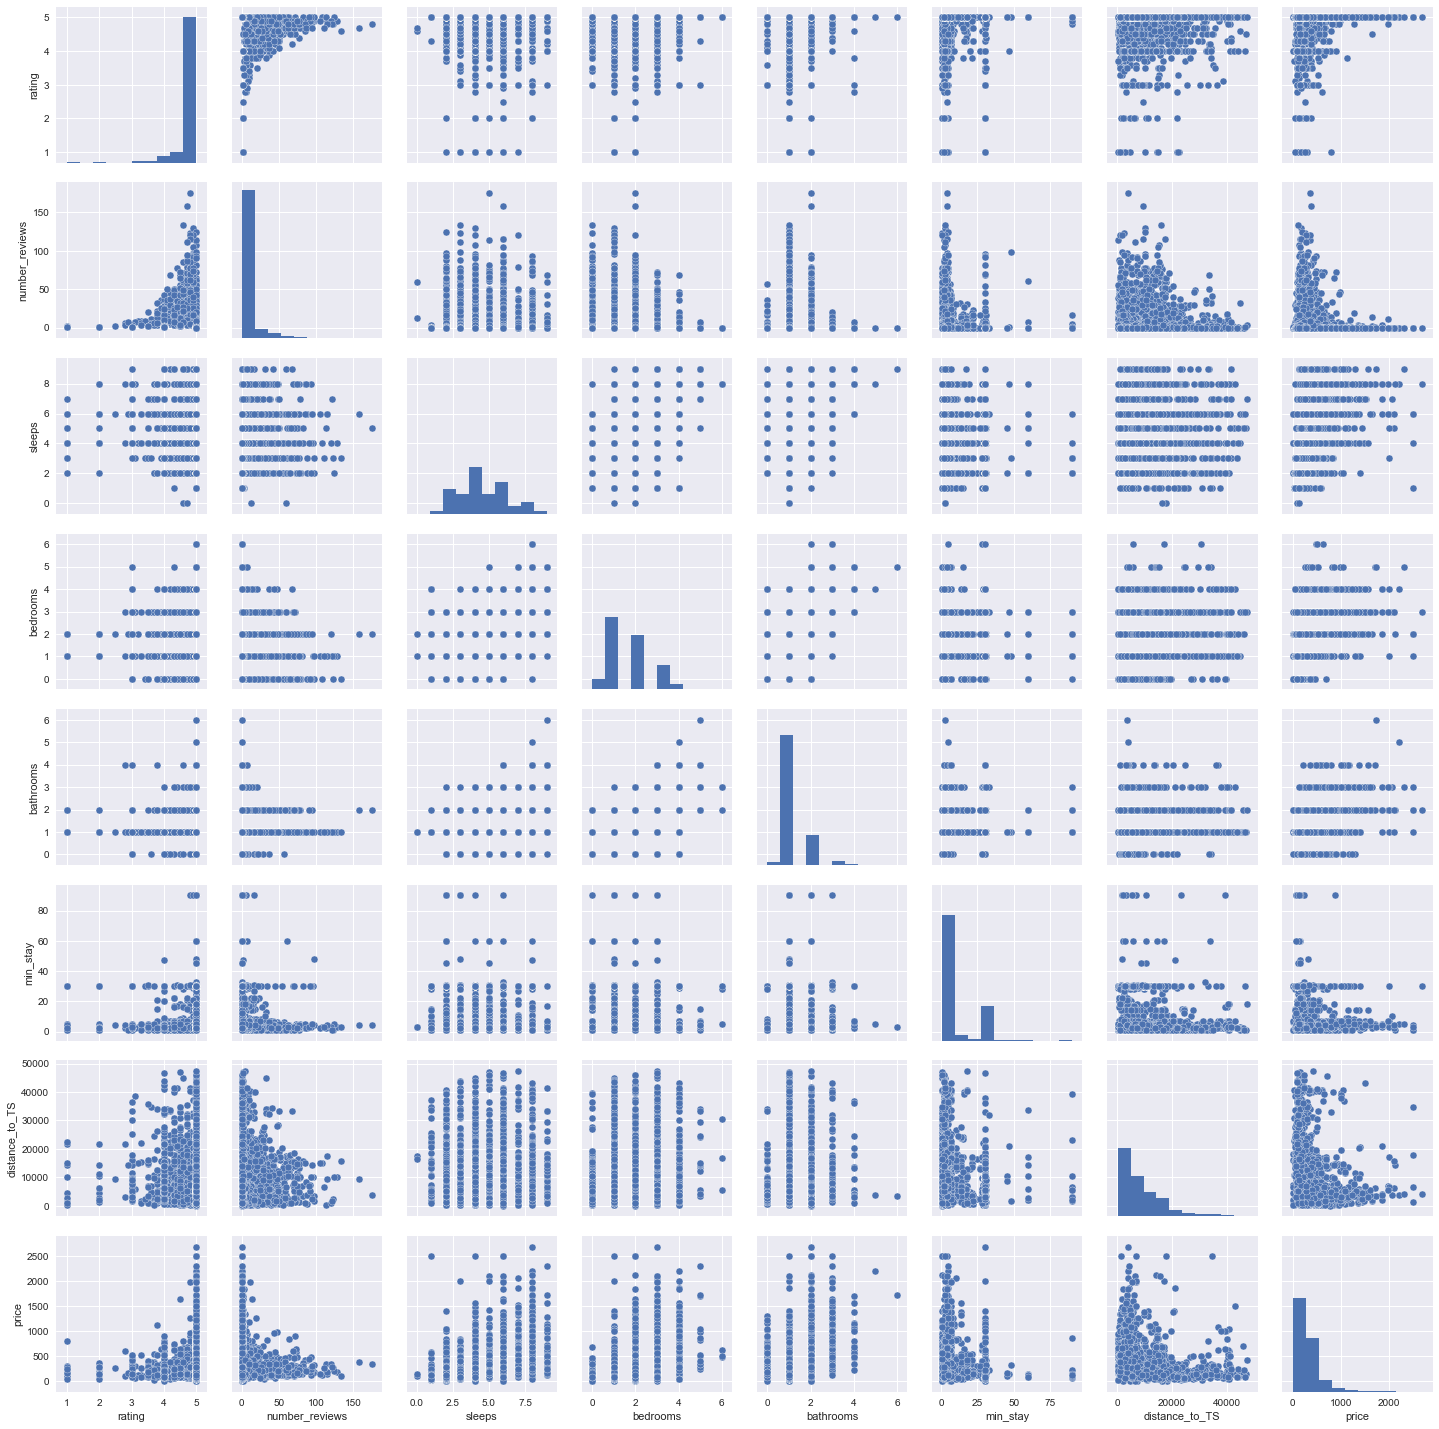

In [9]:
sns.pairplot(df_features)

In [10]:
# df_features['distance_to_TS_2'] = 1/ (df_features['distance_to_TS'])
# sns.pairplot(df_features)

## Multiple Linear Regression with # Bedrooms and # Bathrooms

In [11]:
features_2 = ['bedrooms', 'bathrooms']
lr_model2 = LinearRegression()
lr_model2.fit(X_train.loc[:, features_2], y_train)
list(zip(features_2, lr_model2.coef_))

[('bedrooms', 77.137321764148396), ('bathrooms', 168.34109908242229)]

In [26]:
test_set_pred2 = lr_model2.predict(X_test.loc[:, features_2])

# RMSE
np.sqrt(np.mean((test_set_pred2 - y_test)**2))

221.30710565495974

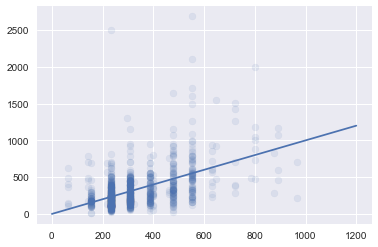

In [27]:
## Plot predicted price vs actual price
plt.scatter(test_set_pred2, y_test, alpha=.1)
plt.plot(np.linspace(0, 1200, 10), np.linspace(0, 1200, 10))

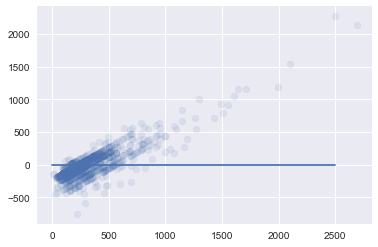

In [22]:
## Residual Plot
plt.scatter(y_test, y_test - test_set_pred2, alpha=.1)
plt.plot(np.linspace(0, 2500, 10), np.linspace(0, 0, 10))

## Multiple Linear Regression with more variables

In [28]:
features_all = ['bedrooms', 'bathrooms',
                'min_stay', 'distance_to_TS']
lr_model_all = LinearRegression()
lr_model_all.fit(X_train.loc[:, features_all], y_train)
list(zip(features_all, lr_model_all.coef_))

[('bedrooms', 86.762279992539462),
 ('bathrooms', 165.13638399903698),
 ('min_stay', -4.3779090022991314),
 ('distance_to_TS', -0.010839345569479519)]

In [30]:
test_set_pred_all = lr_model_all.predict(X_test.loc[:, features_all])

# RMSE
np.sqrt(np.mean((test_set_pred_all - y_test)**2))

208.76166220391568